In [1]:
import os
import time
import h5py
import glob
import time
import numpy as np
import xarray as xr

import pandas as pd
import geopandas as gpd

from datetime import datetime

from shapely.geometry import Point

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import weibull_min
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import curve_fit, minimize, fsolve
from scipy.optimize import differential_evolution

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from pathos.multiprocessing import ProcessingPool as Pool

from playsound import playsound

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_downscale import mev_quant, wei_fit_update, fit_yearly_weibull_update, compute_beta, str_exp_fun, epl_fun, myfun_sse, down_wei
from ART_preprocessing import haversine, create_box, space_time_scales_agregations, wet_matrix_extrapolation, autocorrelation_neighborhood, area_lat_lon, spatial_correlation
from ART_plot import plot_neighborhood, plot_scales_aggregation, plot_wet_fraction_matrix, plot_autocorrelation, plot_scatter

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [13]:
satellite = 'IMERG'
# satellite = 'CMORPH'
# satellite = 'MSWEP'

In [14]:
yy_s, yy_e = 2001, 2023
CONDITION = 'OVERLEAP'; fig_val = 'OVERLAP'

In [15]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [16]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')

if os.path.exists(veneto_dir):
    Veneto = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [17]:
file_name = glob.glob(os.path.join(dir_base,satellite,'3h','*Italy*.nc'))[0]
print(f'File: {file_name}')
data_dir = os.path.join(file_name)

if os.path.exists(data_dir):
    DATA = xr.open_dataset(data_dir)
    DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))
else:
    raise SystemExit(f"File not found: {data_dir}")

lats = np.round(DATA['lat'].data,3)
lons = np.round(DATA['lon'].data,3)

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

year_vector = np.unique(pd.to_datetime(DATA['time']).year)

DATES = DATA['time'][:]

DATA

File: /media/arturo/Arturo/Data/Italy/Satellite/IMERG/3h/IMERG_Italy_3h_2001_01_01_2023_12_31.nc


<xarray.Dataset> Size: 9GB
Dimensions:  (time: 67200, lat: 121, lon: 131)
Coordinates:
  * lat      (lat) float32 484B 35.95 36.05 36.15 36.25 ... 47.75 47.85 47.95
  * lon      (lon) float32 524B 5.95 6.05 6.15 6.25 ... 18.65 18.75 18.85 18.95
  * time     (time) datetime64[ns] 538kB 2001-01-01 ... 2023-12-31T21:00:00
Data variables:
    PRE      (time, lat, lon) float64 9GB ...
Attributes:
    description:  IMERG daily data for Italy region

In [18]:
OBS_base = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'VENETO_INFO_1dy.csv')

if os.path.exists(OBS_INFO_dir):
    INFO_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

In [19]:
names, lats, lons, yys, yye, nys, Ns, Cs, Ws = [], [], [], [], [], [], [], [], []

for nn in range(len(INFO_pd)):
    RAIN_pd = pd.read_csv(os.path.join(OBS_base, 'CLEAR_1dy', f'{INFO_pd['File_Name'].values[nn]}.csv'), sep=',')
    RAIN_pd['TIME'] = pd.to_datetime(RAIN_pd['TIME'].values)
    ss, ee = RAIN_pd['TIME'][0].year, RAIN_pd['TIME'][len(RAIN_pd['TIME'])-1].year
    ny = (ee-ss)+1

    # if ss >= 2001 and ny>=5: # Only station from 2001
    if ny>=10: # Only station with more than 10 years

        RAIN_xr = xr.DataArray(RAIN_pd['PRE'].values,  coords={'time':RAIN_pd['TIME'].values}, dims=('time'))

        RAIN_pd = RAIN_pd.dropna()

        RAIN_Wa = wei_fit_update(RAIN_pd['PRE'].values[RAIN_pd['PRE'].values>1])

        names.append(INFO_pd['File_Name'].values[nn])
        lats.append(INFO_pd['Lat'].values[nn])
        lons.append(INFO_pd['Lon'].values[nn])
        yys.append(ss)
        yye.append(ee)
        nys.append(ny)
        Ns.append(RAIN_Wa[0])
        Cs.append(RAIN_Wa[1])
        Ws.append(RAIN_Wa[2])

    else:
        pass

wa_pd = pd.DataFrame({'File_Name':names, 'Lat':lats, 'Lon':lons, 'YYS':yys, 'YYE':yye, 'NY':nys, 'N':Ns, 'C':Cs, 'W':Ws})

In [20]:
la_max, la_min, lo_max, lo_min = 45, 45.3, 12, 11.5

df_filtered = wa_pd[
    (wa_pd['Lat'] < la_min) & (wa_pd['Lat'] > la_max) &
    (wa_pd['Lon'] > lo_min) & (wa_pd['Lon'] < lo_max)

    ]

df_filtered = df_filtered.reset_index(drop=True)

In [21]:
Tr = np.array([5, 10, 20, 50, 70, 100, 150, 200, 500])
Fi = 1 - 1/Tr
x0 = 9.0*np.nanmean(df_filtered['C'].values)

OBS_Q = []
for ii in range(len(df_filtered)):
    QUANTILE, _ = mev_quant(Fi, x0, df_filtered['N'][ii],df_filtered['C'][ii],df_filtered['W'][ii], thresh=1)
    OBS_Q.append(QUANTILE)

OBS_Q_media = np.mean(np.array(OBS_Q), axis=0)

In [22]:
QUANTILE_M, _ = mev_quant(Fi, x0, np.mean(df_filtered['N'].values),np.mean(df_filtered['C'].values),np.mean(df_filtered['W'].values), thresh=1)

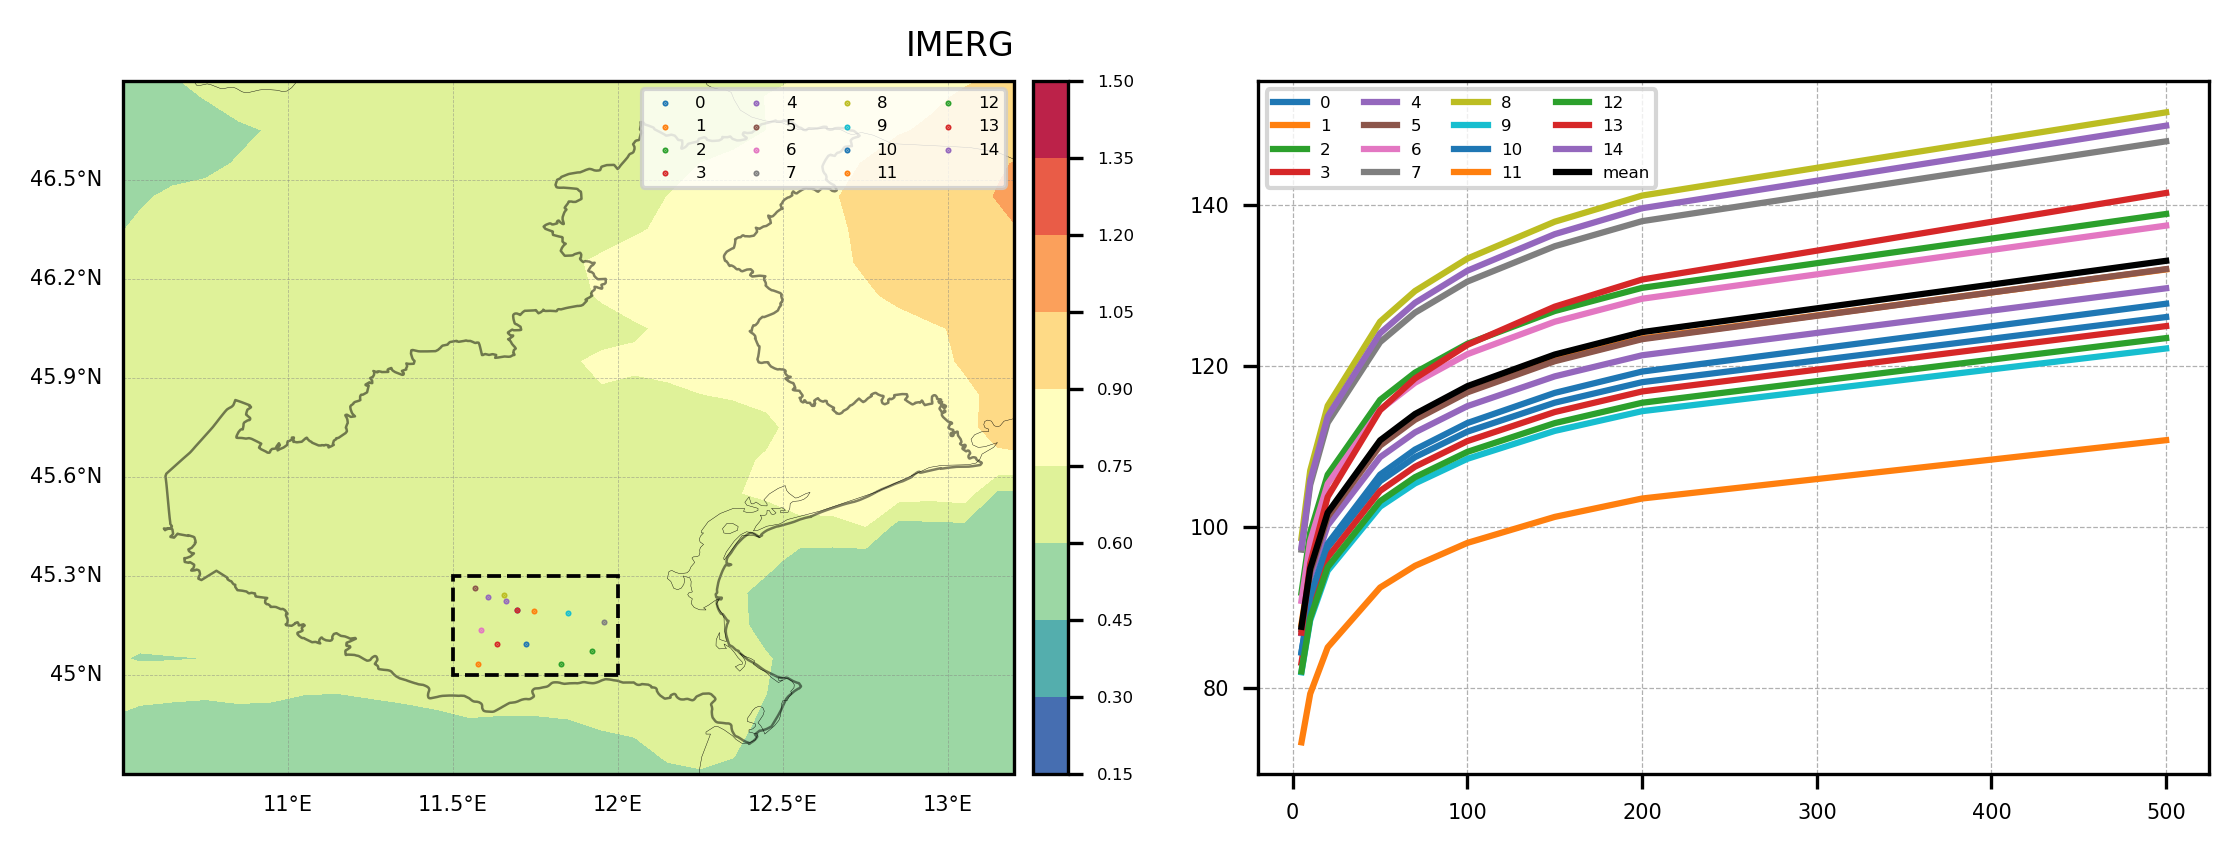

In [23]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

ax1.add_patch(patches.Rectangle((lo_max,la_max),lo_min-lo_max,la_min-la_max,linestyle='--',linewidth=0.9,edgecolor='k',facecolor='None',zorder=10))

for nn in range(len(df_filtered)):
    ax1.scatter(df_filtered['Lon'].values[nn], df_filtered['Lat'].values[nn], s=0.2, zorder=20, label=f'{df_filtered.index[nn]}')
# ax1.scatter(lon2d, lat2d, s=0.2, c='k', zorder=20)

a1 = ax1.contourf(lon2d, lat2d, np.mean(DATA['PRE'],axis=0),cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

ax1.set_title(f'{satellite}', fontsize=8, loc='right')

cbar = plt.colorbar(a1, fraction=0.0367, pad=0.02)
cbar.ax.tick_params(labelsize=4)

ax1.legend(fontsize=4, ncol=4)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1])

for nn in range(len(df_filtered)):
    ax1.plot(Tr, OBS_Q[nn], label=f'{nn}')
ax1.plot(Tr, OBS_Q_media,'-k', linewidth=1.5, label='mean')
# ax1.plot(Tr, QUANTILE_M,'-r', linewidth=1)

plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.grid(linewidth=0.3, linestyle='--')
ax1.legend(fontsize=4, ncol=4)


In [13]:
def ART_downscalling_all(DATA_in, lat_c, lon_c, PARAM):
    PRE_daily = DATA_in.resample(time ='D').sum(dim='time', skipna=False)

    DATES_daily = PRE_daily['time']

    i_ = np.where(lats==lat_c)[0][0]
    j_ = np.where(lons==lon_c)[0][0]

    IMERG_pixel_1dy = PRE_daily['PRE'][:,i_,j_].data

    IMERG_pixel_1dy_xr = xr.DataArray(
                IMERG_pixel_1dy, 
                coords={'time':PRE_daily['time'].values}, 
                dims=('time'))

    SATE_WEIBULL = np.zeros(3)
    c_excesses = IMERG_pixel_1dy[IMERG_pixel_1dy > PARAM['thresh']] - PARAM['thresh']
    SATE_WEIBULL[0], SATE_WEIBULL[1], SATE_WEIBULL[2] = wei_fit_update(c_excesses)

    box_3h, _ = create_box(DATA, lat_c, lon_c, PARAM['npix'], reso=PARAM['radio'])

    smax = box_3h.shape[0] # max spatial scale
    tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*PARAM['dt']
    tscales = tscales[tscales < PARAM['tmax'] + 0.001]
    xscales = np.arange(1, smax+1)
    xscales_km = xscales*PARAM['L1']
    ntscales = np.size(tscales)
    nsscales = np.size(xscales)

    WET_MATRIX = space_time_scales_agregations(
                box_3h, 
                PARAM['L1'], 
                PARAM['condition'], 
                tscales, 
                xscales, 
                PARAM['npix'], 
                PARAM['thresh'])

    xscales_km_2d, tscales_2d = np.meshgrid(xscales_km, tscales)
    ntscales = np.size(tscales)
    nxscales = np.size(xscales)

    tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), PARAM['ninterp'])
    WET_MATRIX_INTER = np.zeros((PARAM['ninterp'], nxscales))
    
    for col in range(nxscales):
        WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX[:, col])

    WET_MATRIX_EXTRA, new_spatial_scale = wet_matrix_extrapolation(
                WET_MATRIX_INTER, 
                xscales_km, 
                tscales_INTER, 
                PARAM['L1'], 
                PARAM['npix'])

    origin_ref = [PARAM['origin_x'], PARAM['origin_t']]
    target_ref = [PARAM['target_x'], PARAM['target_t']]

    beta = compute_beta(WET_MATRIX_EXTRA, origin_ref, target_ref, new_spatial_scale, tscales_INTER)

    vdist, vcorr, distance_vector = autocorrelation_neighborhood(
                box_3h, 
                t_target = PARAM['target_t'], 
                thresh = PARAM['thresh'], 
                cor_method = PARAM['corr_method'])

    vdist_sorted = np.sort(vdist) # order distance
    vcorr_sorted = vcorr[np.argsort(vdist)] # order correlation in relation to distance
    toll_cluster = 0.5

    cluster = np.zeros(len(vdist_sorted))
    count = 0
    for i in range(1, len(vdist_sorted)):
        if np.abs(vdist_sorted[i]-vdist_sorted[i-1]) < toll_cluster:
            cluster[i] = count
        else:
            count = count + 1
            cluster[i] = count

    clust = set(cluster) # Extract only the uniques values
    nclust = len(clust) # Numero de grupos

    vdist_ave = np.zeros(nclust)
    vcorr_ave = np.zeros(nclust)
    for ei, elem in enumerate(clust):
        di = vdist_sorted[cluster==elem] # Distance
        ci = vcorr_sorted[cluster==elem] # Correlation
        vdist_ave[ei] = np.mean(di) # Mean Distance
        vcorr_ave[ei] = np.mean(ci) # Mean Correlation

    # bounds = [(0.0, 200),(0, 1)] # ORIGINAL LIMITS BY ZORZETO
    bounds = [(0.0, 25.0),(0, 0.3)] # NEW LIMITS USING ALL CORRELATIONS FUNCTION IN VENETO
    
    def myfun(pardown):
        return myfun_sse(vdist_ave, vcorr_ave, pardown, PARAM['L1'], acf=PARAM['acf'])

    with Pool(nodes=PARAM['cores']) as pool:
        resmin = differential_evolution(
            myfun,
            bounds,
            disp=True,
            tol=0.05,
            atol=0.05,
            workers=pool.map
        )

    param1 = resmin.x[0]
    param2 = resmin.x[1]

    NYd, CYd, WYd, gamYd, _ = down_wei(
                        SATE_WEIBULL[0], 
                        SATE_WEIBULL[1], 
                        SATE_WEIBULL[2],
                        PARAM['L1'], 
                        PARAM['L0'], 
                        beta, 
                        (param1, param2), 
                        acf=PARAM['acf'])

    DOWN_WEIBULL_YY = np.zeros(3)
    DOWN_WEIBULL_YY[0] = NYd
    DOWN_WEIBULL_YY[1] = CYd
    DOWN_WEIBULL_YY[2] = WYd

    dict_out = dict({'beta':beta, 'gamma':gamYd, 'param1':param1, 'param2':param2})

    return SATE_WEIBULL, DOWN_WEIBULL_YY, dict_out

In [14]:
if satellite == 'IMERG' or satellite == 'MSWEP':
    print(f'{satellite} Data')
    parameters = dict({
        'L1':10,
        'origin_x': 10,
        'radio':0.1,
        'npix':5,
        'thresh': 2,

        'maxmiss':40,
        'condition': 'OVERLEAP',

        'L0':0,
        'tmax': 48,
        'dt': 3,

        'origin_t': 24,
        'target_x': 0,
        'target_t': 24,

        'ninterp':2000,

        'acf': 'mar',
        'corr_method':'pearson',
        'cores': 12,
    })

elif satellite == 'CMORPH':
    print('CMORPH Data')
    parameters = dict({
        'L1':25,
        'origin_x': 25,
        'radio':0.3,
        'npix':3,
        'thresh': 1,

        'maxmiss':40,
        'condition': 'OVERLEAP',

        'L0':0,
        'tmax': 48,
        'dt': 3,

        'origin_t': 24,
        'target_x': 0,
        'target_t': 24,

        'ninterp':2000,

        'acf': 'mar',
        'corr_method':'pearson',
        'cores': 12,
    })

MSWEP Data


In [15]:
POINTS = np.zeros([len(df_filtered),2])
for nn in range(len(df_filtered)):
    distances = haversine(lat2d, lon2d, df_filtered['Lat'].values[nn],df_filtered['Lon'].values[nn])
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    POINTS[nn,0] = lats[min_index[0]]
    POINTS[nn,1] = lons[min_index[1]]

POINTS = np.unique(POINTS, axis=0)
print(f'Number of points: {len(POINTS)}')

Number of points: 7


In [16]:
SATE_WD = []
SATE_SC = []
SATE_SH = []

DOWN_WD = []
DOWN_SC = []
DOWN_SH = []

BETA = []
GAMMA = []

In [17]:
# 547 min para 170 puntos, 3.2 min por punto

start_time = time.time()

step = 1
for nn in range(len(POINTS)):#len(POINTS)
    print(f'PROCESING STEP {step} of {len(POINTS)}')
    latp = np.argwhere((lats==POINTS[nn][0]))[0][0]
    lonp = np.argwhere((lons==POINTS[nn][1]))[0][0]
    # print(latp, lonp)

    SATE_WEIBULL, DOWN_WEIBULL, dict_out, = ART_downscalling_all(DATA, lats[latp], lons[lonp], parameters)

    SATE_WD.append(SATE_WEIBULL[0])
    SATE_SC.append(SATE_WEIBULL[1])
    SATE_SH.append(SATE_WEIBULL[2])

    DOWN_WD.append(DOWN_WEIBULL[0])
    DOWN_SC.append(DOWN_WEIBULL[1])
    DOWN_SH.append(DOWN_WEIBULL[2])

    BETA.append(dict_out['beta'])
    GAMMA.append(dict_out['gamma'])

    step += 1
    print()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

PROCESING STEP 1 of 7
neihgborhood area: 5x5
differential_evolution step 1: f(x)= 0.01330234958171653
differential_evolution step 2: f(x)= 0.01330234958171653
differential_evolution step 3: f(x)= 0.01330234958171653
differential_evolution step 4: f(x)= 0.012028832282534518
Polishing solution with 'L-BFGS-B'
Gamma value: 0.9821539390514467

PROCESING STEP 2 of 7
neihgborhood area: 5x5
differential_evolution step 1: f(x)= 0.0009835441403722033
differential_evolution step 2: f(x)= 0.0009835441403722033
differential_evolution step 3: f(x)= 0.0006756828078766414
differential_evolution step 4: f(x)= 0.0006098687656113486
differential_evolution step 5: f(x)= 0.0006098687656113486
Polishing solution with 'L-BFGS-B'
Gamma value: 0.9926274796874824

PROCESING STEP 3 of 7
neihgborhood area: 5x5
differential_evolution step 1: f(x)= 0.0007321685730701402
differential_evolution step 2: f(x)= 0.0005718178565924008
differential_evolution step 3: f(x)= 0.0005718178565924008
differential_evolution step 

In [22]:
SATE_x0 = 9.0*np.nanmean(SATE_SC)
DOWN_x0 = 9.0*np.nanmean(DOWN_SC)#0.3 for CMORPH

SATE_Q = []
DOWN_Q = []
for ii in range(len(SATE_WD)):
    SQ, _ = mev_quant(Fi, SATE_x0, SATE_WD[ii], SATE_SC[ii], SATE_SH[ii], thresh=1)
    DQ, _ = mev_quant(Fi, DOWN_x0, DOWN_WD[ii], DOWN_SC[ii], DOWN_SH[ii], thresh=1)
    SATE_Q.append(SQ)
    DOWN_Q.append(DQ)

SATE_Q_media = np.mean(np.array(SATE_Q), axis=0)
DOWN_Q_media = np.mean(np.array(DOWN_Q), axis=0)

In [23]:
SATE_DF = pd.DataFrame({'Tr':Tr, 'SATE_MEAN':SATE_Q_media, 'DOWN_MEAN':DOWN_Q_media})

df_out = f'../data/return_time/Veneto_{satellite}.csv'
print(f'Export as: {df_out}')
SATE_DF.to_csv(df_out, header=True, index=None)

Export as: ../data/return_time/Veneto_MSWEP.csv


In [24]:
PARAM_DF = pd.DataFrame({'BETA':BETA, 'GAMMA':GAMMA})

df_out = f'../data/return_time/Veneto_{satellite}_Beta_Gamma.csv'
print(f'Export as: {df_out}')
PARAM_DF.to_csv(df_out, header=True, index=None)

Export as: ../data/return_time/Veneto_MSWEP_Beta_Gamma.csv


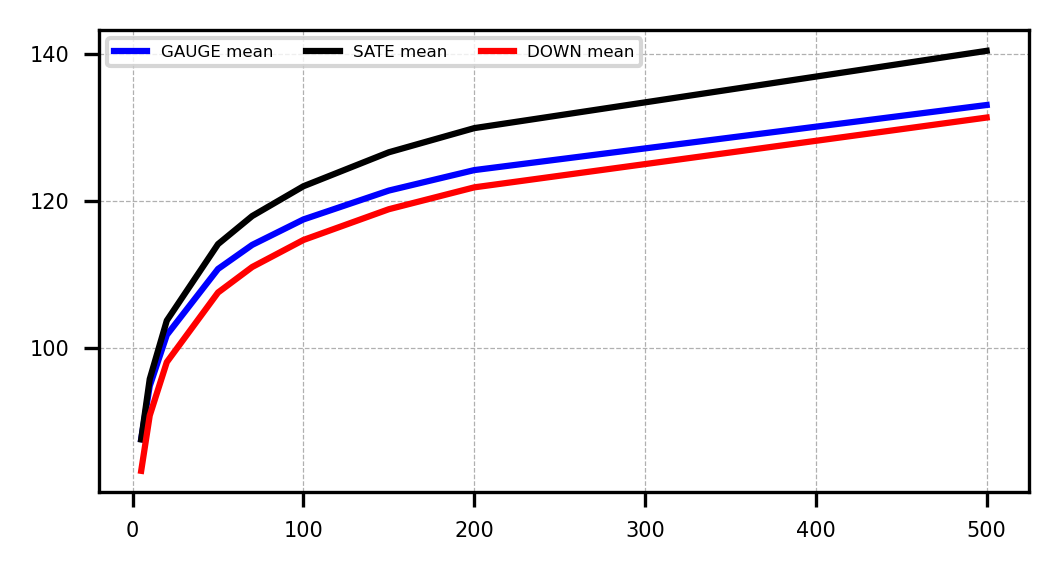

In [25]:
fig = plt.figure(figsize=(4,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0])

ax1.plot(Tr, OBS_Q_media,'-b', linewidth=1.5, label='GAUGE mean')
ax1.plot(Tr, SATE_Q_media,'-k', linewidth=1.5, label='SATE mean')
ax1.plot(Tr, DOWN_Q_media,'-r', linewidth=1.5, label='DOWN mean')

plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.grid(linewidth=0.3, linestyle='--')
ax1.legend(fontsize=4, ncol=4)